In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats
import phik
import graphviz
import lightgbm
import warnings
import sklearn
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree as xgbtree
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from scipy.stats import uniform
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")
sb.set_theme()

## Data Visualization

In [2]:
churndata = pd.read_csv('churn_model.csv')  #extracting data
churndata.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
#converting Area code(numerical type) to categorical
churndata['Area code'] = churndata['Area code'].astype('object')    
print(churndata.dtypes)

State                      object
Account length              int64
Area code                  object
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object


## Splitting data set into Categorical and Numerical types

In [4]:
churn_num_data = churndata.select_dtypes(exclude=[object])

In [5]:
print(churn_num_data.dtypes)

Account length              int64
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object


In [6]:
churn_cat_data = churndata.select_dtypes(include=[object,bool])

In [7]:
print(churn_cat_data.dtypes)

State                 object
Area code             object
International plan    object
Voice mail plan       object
Churn                   bool
dtype: object


## Data Processing

In [8]:
#One hot encoding to convert categorical variables into numerical

churn_cat = churndata.select_dtypes(include=[object]).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(churndata[churn_cat])
encoded_cat_df = pd.DataFrame(encoded_data,columns = encoder.get_feature_names_out(churn_cat))
churn_OHE = churndata
churn_OHE = churn_OHE.drop(churn_cat,axis = 1)                  #removal of old categorical data from dataset
churn_OHE = pd.concat([churn_OHE, encoded_cat_df],axis = 1)     #appending new one hot encoded variables into dataseet
print(f"Encoded data : \n{churn_OHE}")

Encoded data : 
      Account length  Number vmail messages  Total day minutes  \
0                128                     25              265.1   
1                107                     26              161.6   
2                137                      0              243.4   
3                 84                      0              299.4   
4                 75                      0              166.7   
...              ...                    ...                ...   
2661              79                      0              134.7   
2662             192                     36              156.2   
2663              68                      0              231.1   
2664              28                      0              180.8   
2665              74                     25              234.4   

      Total day calls  Total day charge  Total eve minutes  Total eve calls  \
0                 110             45.07              197.4               99   
1                 123            

# Models

## Train-Test-split and SMOTE

In [9]:
#since our data is heavily skewed towards False(churn), we used SMOTE to balance our dataset

Predictors = churn_OHE.drop(['Churn'],axis = 1)
Response = churn_OHE['Churn']

Predictors_train , Predictors_test, Response_train, Response_test = train_test_split(Predictors, Response, test_size = 0.2, random_state= 10)
smt = SMOTE(random_state= 10)
Predictors_train , Response_train = smt.fit_resample(Predictors_train,Response_train)

  File "c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


## Classification Tree Model

In [10]:
#Classification Tree
Ctree = DecisionTreeClassifier(random_state=0)
Ctree.fit(Predictors_train, Response_train)
Response_pred = Ctree.predict(Predictors_test)

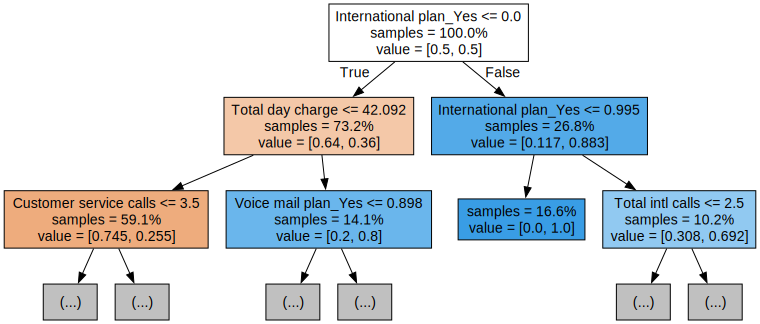

In [11]:
dot_data = export_graphviz(Ctree, 
                            feature_names = Predictors_train.columns,
                            filled = True,
                            max_depth = 2,
                            impurity = False,
                            proportion = True)
graph = graphviz.Source(dot_data)
display(graph)

Text(0.5, 427.9555555555555, 'Predicted Churn')

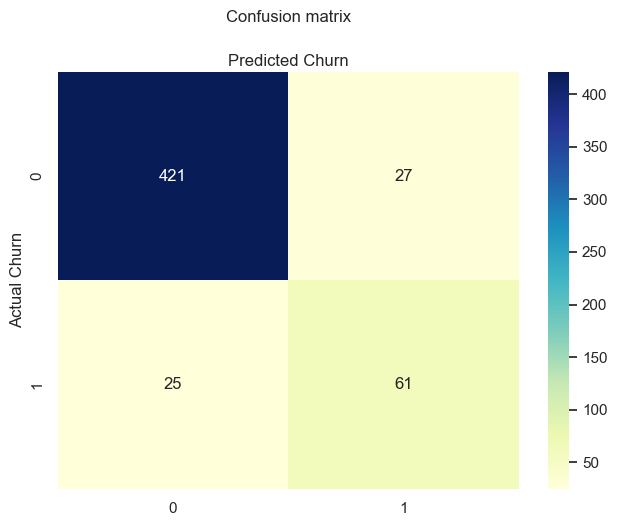

In [12]:
#creating visualization of predicted and actual results
cnf_matrix = confusion_matrix(Response_test, Response_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

In [13]:
#Classification Tree results
print(classification_report(y_true=Response_test,y_pred=Response_pred,digits = 3))
accuracy = accuracy_score(Response_test,Response_pred)

print("Accuracy : ", accuracy)

probs = Ctree.predict_proba(Predictors_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response_test, preds)
roc_auc = metrics.auc(fpr, tpr)

print("ROC AUC: ", roc_auc)


              precision    recall  f1-score   support

       False      0.944     0.940     0.942       448
        True      0.693     0.709     0.701        86

    accuracy                          0.903       534
   macro avg      0.819     0.825     0.821       534
weighted avg      0.904     0.903     0.903       534

Accuracy :  0.9026217228464419
ROC AUC:  0.8245172342192691


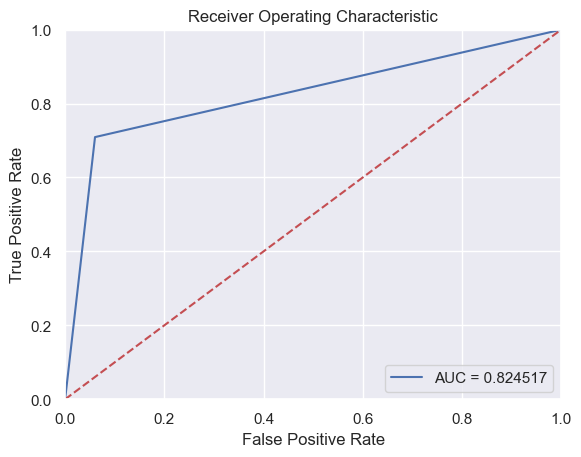

In [14]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest Model

In [15]:
#random Forest model
rf = RandomForestClassifier()
rf.fit(Predictors_train, Response_train)

RandomForestClassifier()

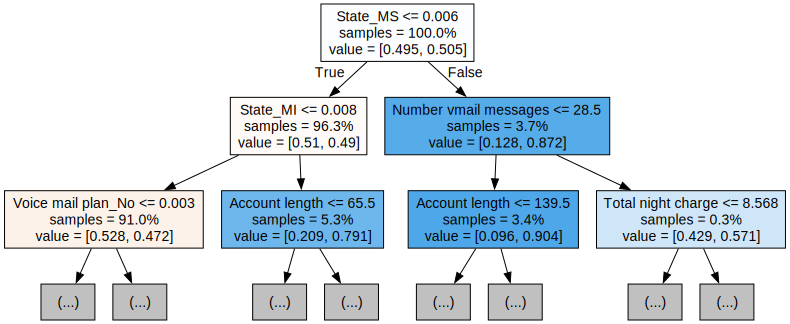

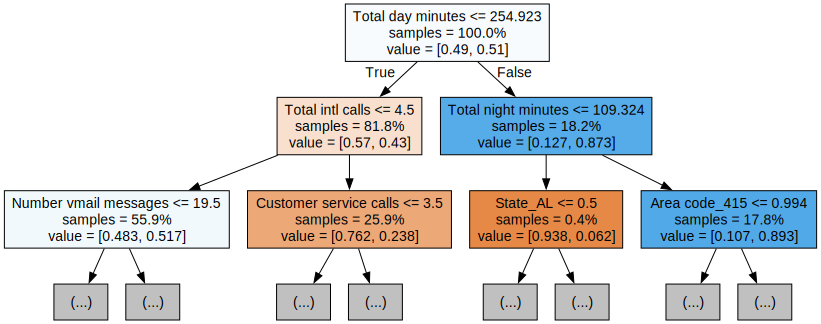

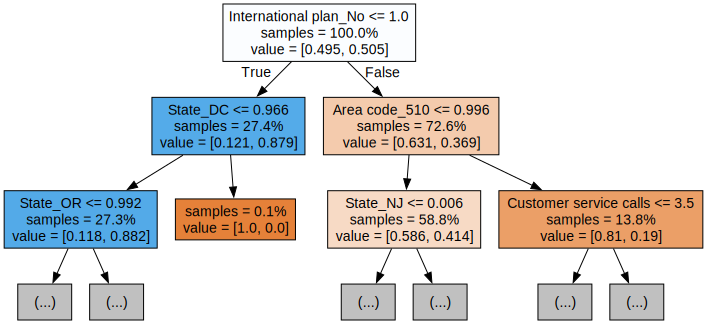

In [16]:
#sample of decision tress within random forest
for i in range(3):
    rftree = rf.estimators_[i]
    dot_data = export_graphviz(rftree, 
                               feature_names = Predictors_train.columns,
                               filled = True,
                               max_depth = 2,
                               impurity = False,
                               proportion = True)
    graph = graphviz.Source(dot_data)
    display(graph)

Text(0.5, 427.9555555555555, 'Predicted Churn')

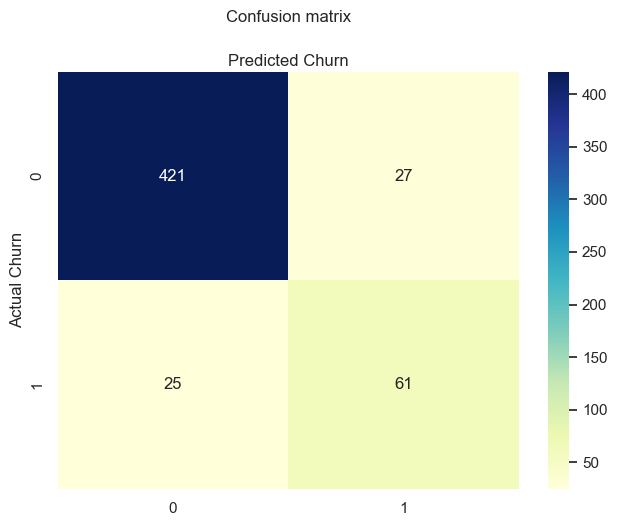

In [17]:
#creating visualization of predicted and actual results
cnf_matrix = confusion_matrix(Response_test, Response_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

In [18]:
#Random Forest results
Response_predict = rf.predict(Predictors_test)
print(classification_report(y_true=Response_test,y_pred=Response_predict,digits = 3))
accuracy = accuracy_score(Response_test,Response_predict)

print("Accuracy : ", accuracy)

probs = rf.predict_proba(Predictors_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response_test, preds)
roc_auc = metrics.auc(fpr, tpr)

print("ROC AUC:", roc_auc)

              precision    recall  f1-score   support

       False      0.932     0.978     0.954       448
        True      0.844     0.628     0.720        86

    accuracy                          0.921       534
   macro avg      0.888     0.803     0.837       534
weighted avg      0.918     0.921     0.917       534

Accuracy :  0.9213483146067416
ROC AUC: 0.9027849875415281


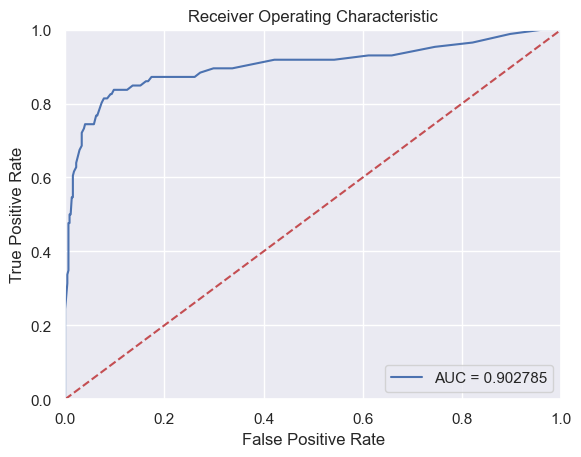

In [19]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest with Hyper Parameters

In [20]:
#hyper parameters tuning
param_dist = {'n_estimators': randint(1,1000),
              'max_depth': randint(1,100)}

rand_search = RandomizedSearchCV(rf,param_distributions=param_dist,
                                 n_iter=30,cv=10, n_jobs=-1,
                                 scoring='accuracy')

rand_search.fit(Predictors_train,Response_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B43D9E7140>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B43FCC9250>},
                   scoring='accuracy')

In [21]:
#tuning results
best_rf = rand_search.best_estimator_
print("Best hyperparameters:", best_rf)
Response_predict = best_rf.predict(Predictors_test)

Best hyperparameters: RandomForestClassifier(max_depth=45, n_estimators=846)


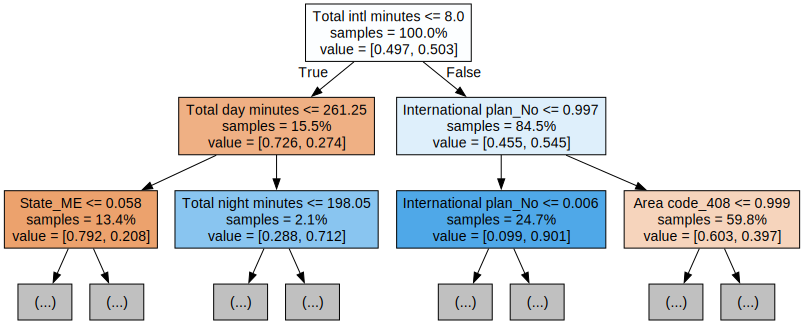

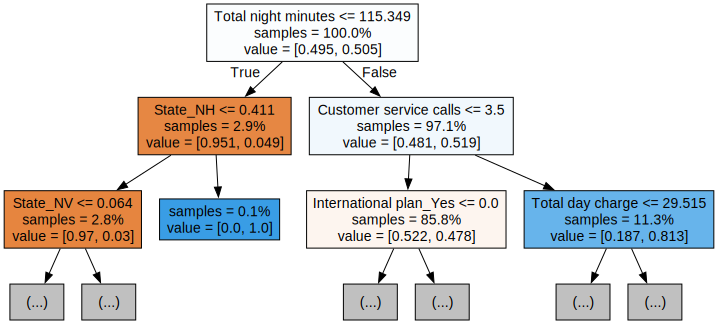

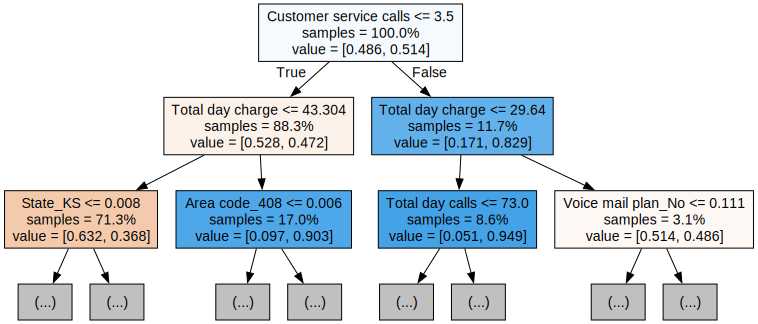

In [22]:
#sample of decision tress within random forest with hyper parameters
for i in range(3):
    rftree = best_rf.estimators_[i]
    dot_data = export_graphviz(rftree, 
                               feature_names = Predictors_train.columns,
                               filled = True,
                               max_depth = 2,
                               impurity = False,
                               proportion = True)
    graph = graphviz.Source(dot_data)
    display(graph)

International plan_Yes    0.095988
Total day charge          0.095985
International plan_No     0.094629
Total day minutes         0.094003
Customer service calls    0.062736
Area code_415             0.045723
Area code_408             0.035485
Area code_510             0.035259
Total eve charge          0.032064
Total eve minutes         0.031137
dtype: float64

<Axes: >

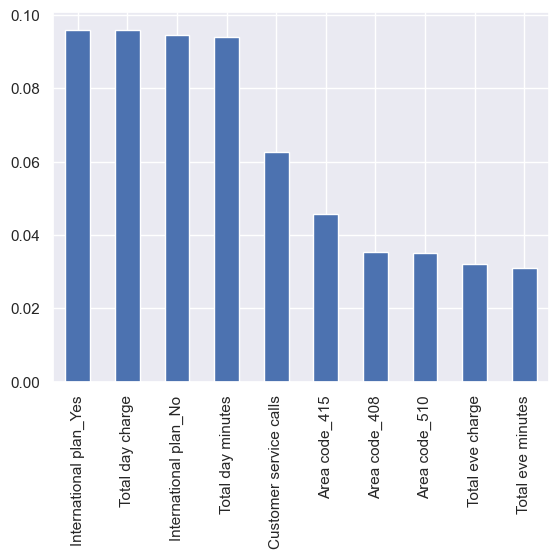

In [23]:
#importance of certain variables to predict churn
feature_importance = pd.Series(best_rf.feature_importances_,
                               index = Predictors_train.columns).sort_values(ascending=False)
feature_importance_trunc = feature_importance.iloc[0:10]
print(feature_importance_trunc)
feature_importance_trunc.plot.bar()

Text(0.5, 427.9555555555555, 'Predicted Churn')

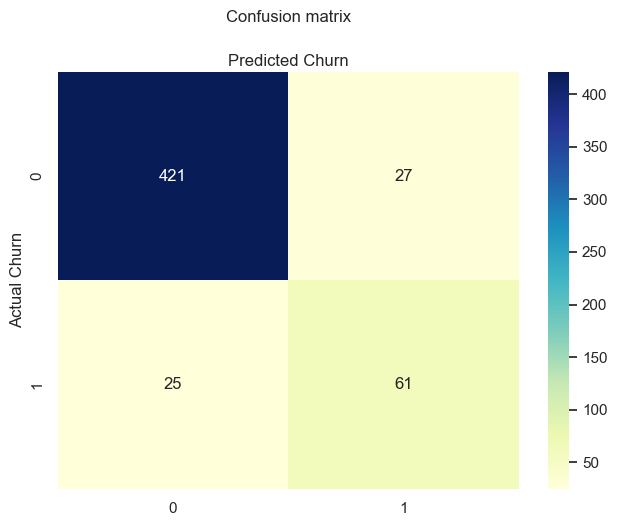

In [24]:
#creating visualization of predicted and actual results
cnf_matrix = confusion_matrix(Response_test, Response_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

In [25]:
#results of Random Forest with Hyper parameters
print(classification_report(Response_test,Response_predict,digits = 3))
accuracy = accuracy_score(Response_test,Response_predict)

print("Accuracy :", accuracy)

probs = best_rf.predict_proba(Predictors_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response_test, preds)
roc_auc = metrics.auc(fpr, tpr)

print("ROC AUC:", roc_auc)

              precision    recall  f1-score   support

       False      0.932     0.984     0.958       448
        True      0.885     0.628     0.735        86

    accuracy                          0.927       534
   macro avg      0.909     0.806     0.846       534
weighted avg      0.925     0.927     0.922       534

Accuracy : 0.9269662921348315
ROC AUC: 0.9016818936877076


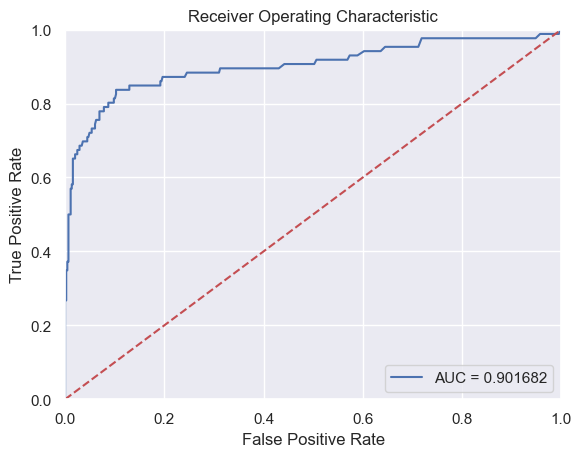

In [26]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Cross Checking and Validation of Model

In [27]:
#Checking model accuracy against new set of test data
#To determine overfitting / underfitting
churn_test_data = pd.read_csv('churn_test.csv')

In [28]:
#One hot encoding the test data
churn_test_cat = churn_test_data.select_dtypes(include=[object]).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_test_data = encoder.fit_transform(churn_test_data[churn_test_cat])
encoded_test_cat_df = pd.DataFrame(encoded_test_data,columns = encoder.get_feature_names_out(churn_test_cat))
churn_test_OHE = churn_test_data
churn_test_OHE = churn_test_OHE.drop(churn_test_cat,axis = 1)
churn_test_OHE = pd.concat([churn_test_OHE, encoded_test_cat_df],axis = 1)
print(f"Encoded data : \n{churn_test_OHE}")

Encoded data : 
     Account length  Area code  Number vmail messages  Total day minutes  \
0               117        408                      0              184.5   
1                65        415                      0              129.1   
2               161        415                      0              332.9   
3               111        415                      0              110.4   
4                49        510                      0              119.3   
..              ...        ...                    ...                ...   
662             114        415                     26              137.1   
663             106        408                     29               83.6   
664              60        415                      0              193.9   
665             159        415                      0              169.8   
666             184        510                      0              213.8   

     Total day calls  Total day charge  Total eve minutes  Total eve ca

In [29]:
#splitting churn and other variables
Response = churn_OHE['Churn']
Predictors = churn_OHE.drop(['Churn'],axis = 1)

### Classification Tree

              precision    recall  f1-score   support

       False      0.989     0.988     0.989      2278
        True      0.931     0.936     0.933       388

    accuracy                          0.980      2666
   macro avg      0.960     0.962     0.961      2666
weighted avg      0.981     0.980     0.981      2666

Accuracy :  0.9804951237809453
ROC AUC: 0.9618572540571853


<Axes: >

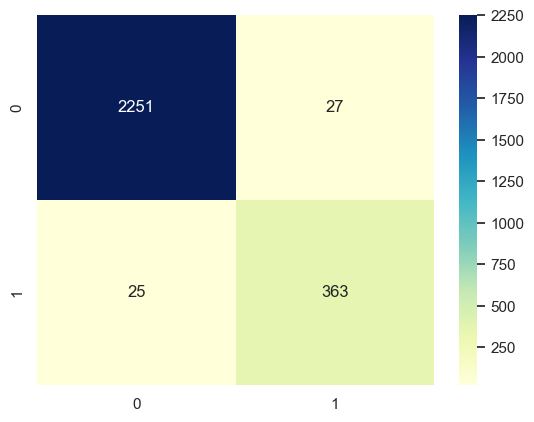

In [30]:
#Validating Classification Tree Model
CT_Response_predict = Ctree.predict(Predictors)
print(classification_report(y_true=Response,y_pred=CT_Response_predict,digits = 3))
accuracy = accuracy_score(Response,CT_Response_predict)

print("Accuracy : ", accuracy)


probs = Ctree.predict_proba(Predictors)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response, preds)
roc_auc = metrics.auc(fpr, tpr)


print("ROC AUC:", roc_auc)
cm = confusion_matrix(Response,CT_Response_predict)
sb.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

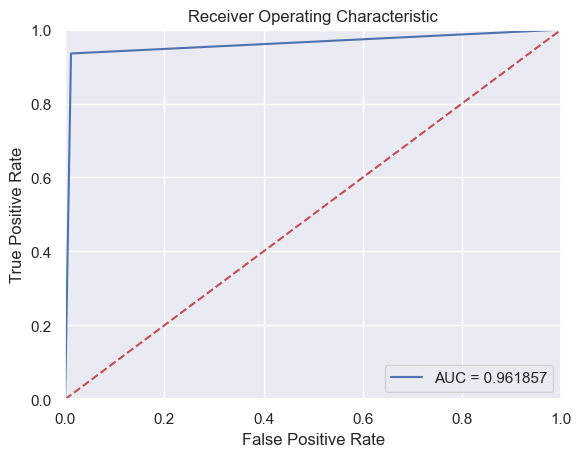

In [31]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forest

              precision    recall  f1-score   support

       False      0.986     0.996     0.991      2278
        True      0.973     0.918     0.944       388

    accuracy                          0.984      2666
   macro avg      0.979     0.957     0.968      2666
weighted avg      0.984     0.984     0.984      2666

Accuracy :  0.9842460615153789
ROC : 0.9891946045998028


<Axes: >

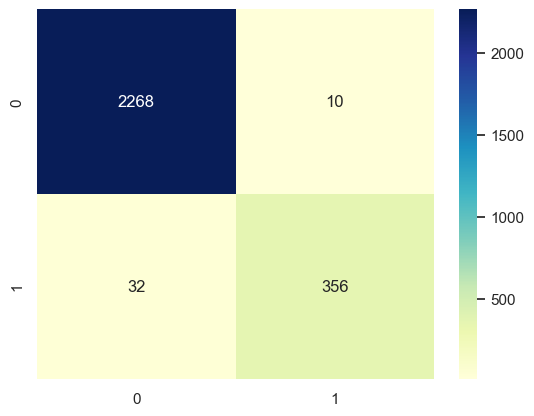

In [32]:
#Validating Random Forest Model
RF_Response_predict = rf.predict(Predictors)
print(classification_report(y_true=Response,y_pred=RF_Response_predict,digits = 3))
accuracy = accuracy_score(Response,RF_Response_predict)

print("Accuracy : ", accuracy)

probs = rf.predict_proba(Predictors)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response, preds)
roc_auc = metrics.auc(fpr, tpr)

print("ROC :", roc_auc)

cm = confusion_matrix(Response,RF_Response_predict)
sb.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

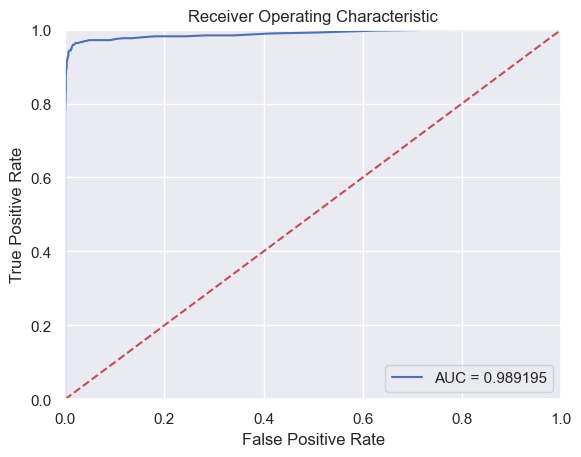

In [33]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random Forest with Hyperparameter

              precision    recall  f1-score   support

       False      0.986     0.997     0.991      2278
        True      0.981     0.918     0.948       388

    accuracy                          0.985      2666
   macro avg      0.983     0.957     0.970      2666
weighted avg      0.985     0.985     0.985      2666

Accuracy :  0.9853713428357089
ROC AUC: 0.9891357720192248


<Axes: >

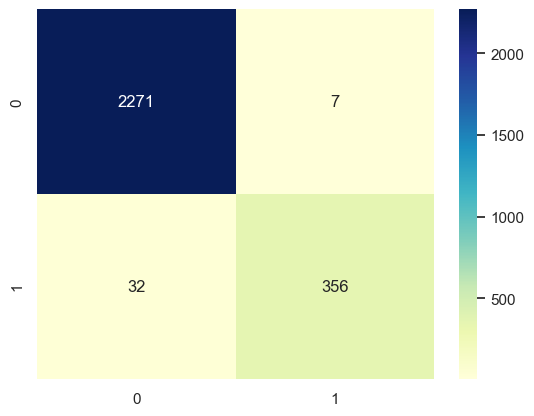

In [34]:
#Validating Random Forest with Hyperparameter Model
RFH_Response_predict = best_rf.predict(Predictors)
print(classification_report(y_true=Response,y_pred=RFH_Response_predict,digits = 3))
accuracy = accuracy_score(Response,RFH_Response_predict)

print("Accuracy : ", accuracy)

probs = best_rf.predict_proba(Predictors)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response, preds)
roc_auc = metrics.auc(fpr, tpr)

print("ROC AUC:", roc_auc)


cm = confusion_matrix(Response,RFH_Response_predict)
sb.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

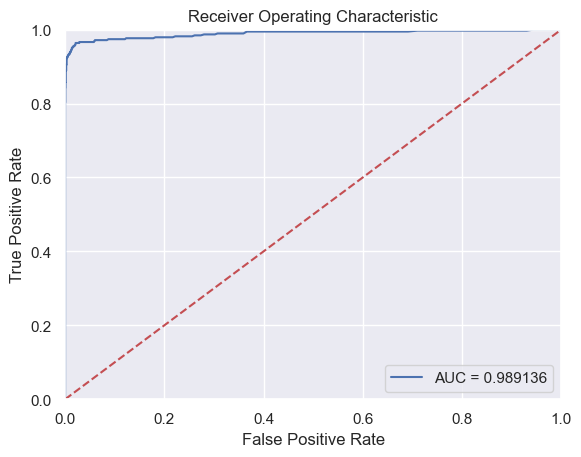

In [35]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Plot table and graph of performance measure

In [36]:
dict = {
        'Accuracy':[0.792, 0.990, 0.980, 0.985, 0.985, 0.989] ,
        'ROC AUC': [0.836, 0.981, 0.962, 0.989,0.989,0.984] ,
        'Precision': [0.388, 0.987, 0.931, 0.975,0.978,0.984] ,
        'Recall': [0.747, 0.946, 0.936, 0.918, 0.918, 0.938] ,
        'F1-score': [0.511, 0.966, 0.933,0.946, 0.947, 0.960] ,
        }


list = ['Logistic Regression','XGBoost','Classifcation Tree','Random Forest', 'Random Forest w/ hyperparameter','LightGBM']

In [37]:
performance = pd.DataFrame(dict, index = list)
performance.sort_values(by="Accuracy",ascending=False)

,Accuracy,ROC AUC,Precision,Recall,F1-score
XGBoost,0.990,0.981,0.987,0.946,0.966
LightGBM,0.989,0.984,0.984,0.938,0.960
Random Forest,0.985,0.989,0.975,0.918,0.946
Random Forest w/ hyperparameter,0.985,0.989,0.978,0.918,0.947
Classifcation Tree,0.980,0.962,0.931,0.936,0.933
Logistic Regression,0.792,0.836,0.388,0.747,0.511


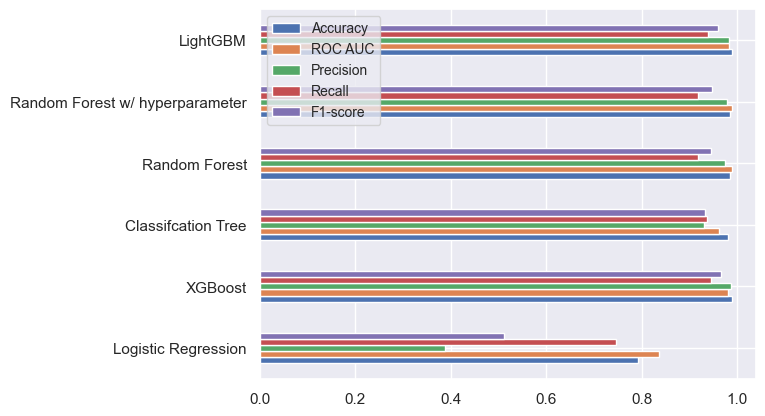

In [38]:
performance.plot.barh()
plt.legend(loc='upper left',fontsize='small')
plt.show()

<h4> 
Model Ranking:
Assessed via Accuracy and ROC

1) XGBOOST                                  (Acc:0.990 / ROC: 0.981)
2) Light GBM                                (Acc:0.989 / ROC: 0.984)
3) Random Forest with Hyper Parameter       (Acc:0.985 / ROC: 0.989)
4) Random Forest                            (Acc:0.985 / ROC: 0.989)
5) Classification Tree                      (Acc:0.980 / ROC: 0.962)
6) Logistic Regression                      (Acc:0.792 / ROC: 0.836)

</h4>